In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

import thinkbayes
from thinkbayes import Pmf
from thinkbayes import Suite
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# 추정 2
___

## 1. 유로 문제

- 동전 회전을 250번 시행
- 앞면이 140회, 뒷면이 110회 나옴
- LSE의 베리 브라이트 교수는 '동전이 기울지 않는 이상 결과가 이렇게 치우칠 확률은 7% 미만이다' 라고 언급
- **위 데이터로 동전이 기울었음을 증명할 수 있을까?**

> 1. 동전이 앞면이 나올 확률을 추정
> 2. 데이터가 동전이 기울었다는 가설에 부합하는지 확인

- 가설 $H_x$는 1에서 100까지 앞면이 나올 확률이 $x\%$임
- 동전을 던져서 무언가 나올 확률은 균등 사전분포에서 시작 (hypotheses = range(1,101))
- 우도함수는 다음과 같이 규정할 수 있음 $p(H) = x/100$, $p(T) = (100-x)/100$

In [2]:
class Euro(Suite):
    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':
            return x/100
        else:
            return (100-x)/100

In [3]:
suite = Euro(range(0,101))
dataset = 'H'*140 + 'T'*110

for data in dataset:
    suite.Update(data)

suite.d

{0: 0.0,
 1: 1.2563304589679406e-207,
 2: 5.731921084330737e-166,
 3: 8.338710825995312e-142,
 4: 8.269264884325567e-125,
 5: 9.652274676137561e-112,
 6: 3.668355640015438e-101,
 7: 2.6673648652111617e-92,
 8: 1.067804311922848e-84,
 9: 4.653041866667465e-78,
 10: 3.5148639684269944e-72,
 11: 6.41370730237118e-67,
 12: 3.6116101639380365e-62,
 13: 7.558221138889982e-58,
 14: 6.791834819435185e-54,
 15: 2.938262414300847e-50,
 16: 6.710448103474771e-47,
 17: 8.723115797935806e-44,
 18: 6.869212634536842e-41,
 19: 3.452142332222388e-38,
 20: 1.1569922381844238e-35,
 21: 2.684811430039415e-33,
 22: 4.454655201037467e-31,
 23: 5.433870634035609e-29,
 24: 4.992309179721862e-27,
 25: 3.5283582174022986e-25,
 26: 1.954296119578907e-23,
 27: 8.623311588848912e-22,
 28: 3.0756115185781603e-20,
 29: 8.981948245990872e-19,
 30: 2.1726638865771484e-17,
 31: 4.3981455873488677e-16,
 32: 7.519861568782927e-15,
 33: 1.0949955730436074e-13,
 34: 1.3680871977846058e-12,
 35: 1.476481205621615e-11,
 36:

Text(0.5,1,'Prior of uniform distribution\n')

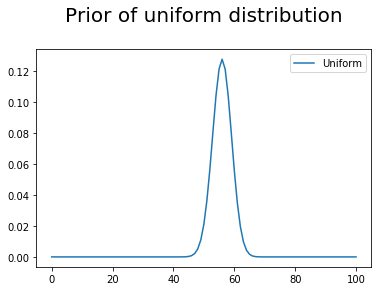

In [4]:
pd.Series(suite.d, index = suite.d.keys()).plot(label = 'Uniform')
plt.legend()
plt.title('Prior of uniform distribution\n', size = 20)

___
## 2. 사후 확률 요약하기

- 위 사후확률 분포를 요약하는 방법에는 여러 가지가 있음
- 한 가지 방법으로는 사후 확률 분포에 가장 근접한 값을 찾는 것이고, 최대 우도 추정값이 될 수 있음
- thinkbayes에서는 아래와 같이 최대 우도 추정 가능

~~~python
    def MaximumLikelihood(self):
        """Returns the value with the highest probability.
        Returns: float probability
        """
        prob, val = max((prob, val) for val, prob in self.Items())
        return val
~~~

In [5]:
suite.MaximumLikelihood()

56

- 혹은 아래와 같이 평균, 또는 중간값으로 요약 가능

In [6]:
suite.Mean()

55.95238095238094

In [7]:
thinkbayes.Percentile(suite, 50)

56

- 마지막으로 신뢰구간으로 요약도 가능

In [8]:
thinkbayes.CredibleInterval(suite, 90)

(51, 61)

>- 위 결과로 추론하건대, 90% 신뢰구간에서 동전이 평평하다고($H_x = 50\%$) 주장 할 수 없음
>- 다만, 이는 **"데이터로 동전이 기울었음을 증명할 수 있을까?"라는 원 질문과는 다름**
>- 이 질문에 대답하기 위해서는 <U>**데이터가 가설에 대해 증거를 갖추고 있다는 것이 어떤 의미인지**</U> 확인 필요

___
## 3. 사전 분포 범람

- 만약 동전이 한쪽으로 치우쳐 있다면 **사전확률이 균등분포를 따른다고 보기는 어려움**
- 50%에 가까운 $x$에 더 높은 확률을 부여하고 극단 값에 낮은 확률을 부여하는 삼각 사전확률을 대안으로 점검

In [9]:
def TrianglePrior():
    global suite
    suite = Euro()
    for x in range(0, 51):
        suite.Set(x,x)
    for x in range(51, 101):
        suite.Set(x, 100-x)
    suite.Normalize()

In [10]:
#TrianglePrior()

suite = Euro(range(0,101))

suite_tr = Euro()
for x in range(0, 51):
    suite_tr.Set(x,x)
for x in range(51, 101):
    suite_tr.Set(x, 100-x)
suite_tr.Normalize()

2500

Text(0.5,1,'Prior of uniform distribution and triangle distribution\n')

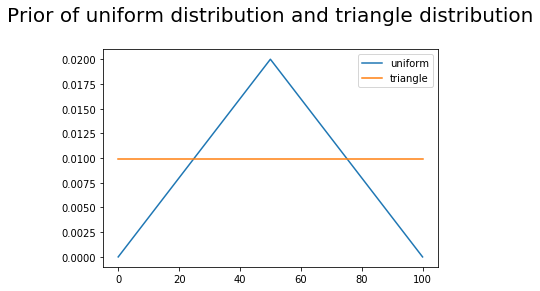

In [11]:
prior_prob = pd.DataFrame({'range': range(0,101), 'uniform': [i for i in suite.d.values()], 'triangle': [i for i in suite_tr.d.values()]})

plot(prior_prob.iloc[:,1], label = 'uniform')
plot(prior_prob.iloc[:,2], label = 'triangle')
plt.legend()
plt.title('Prior of uniform distribution and triangle distribution\n', size = 20)

- 사전 분포에 따른 사후분포는 아래와 같이 확인 가능

In [12]:
for data in dataset:
    suite.Update(data)
    suite_tr.Update(data)

Text(0.5,1,'Posterior of uniform distribution and triangle distribution\n')

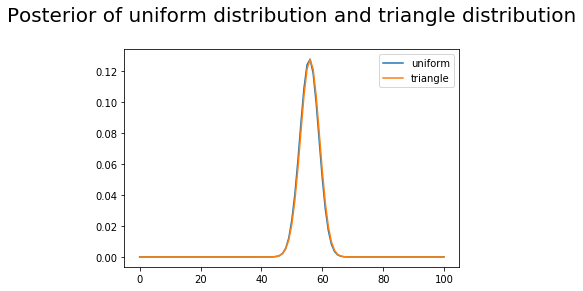

In [13]:
post_prob = pd.DataFrame({'range': range(0,101), 'uniform': [i for i in suite.d.values()], 'triangle': [i for i in suite_tr.d.values()]})

plot(post_prob.iloc[:,1], label = 'uniform')
plot(post_prob.iloc[:,2], label = 'triangle')
plt.legend()
plt.title('Posterior of uniform distribution and triangle distribution\n', size = 20)

- 사후확률의 최대우도값

In [14]:
print((suite.MaximumLikelihood(),suite.d[suite.MaximumLikelihood()]), (suite_tr.MaximumLikelihood(),suite.d[suite_tr.MaximumLikelihood()]))

(56, 0.12745318058391283) (56, 0.12745318058391283)


- 사후확률의 평균

In [15]:
print(suite.Mean(), suite_tr.Mean())

55.95238095238094 55.74349943859503


- 사후확률의 구간추정 (90%)

In [16]:
print(suite.CredibleInterval(), suite_tr.CredibleInterval())

(51, 61) (51, 61)


- 두 사전분포로부터 도출한 사후분포는 매우 유사한 형태를 띄게 됨
- 최대우도값과 구간추정은 동일하고, 평균은 0.5% 미만의 차이를 보임
- 이는 **사전분포범람 (swamping the prior)**의 예시로, 데이터가 충분하다면 서로 다른 사전확률을 가지고도 동일한 사후확률로 수렴하는 경향이 있음

___
## 4. 최적화

- 상기 코드는 이해하기 쉽지만 보다 효율적으로 작동하기 위해 최적화를 수행할 필요가 있음
- 런타임을 고려한다면 속도를 향상시킬 몇가지 방법이 있음
> #### 1. Update 최적화: suite에 likelihood를 곱할 때 마다 정규화 하는 대신, 모든 likelihood를 적용 후 정규화 수행  
> #### 2. Likelihood 최적화: 한회씩 데이터셋을 호출하는 대신 전체 데이터셋을 처리하도록 재작성

- 개선하고자 하는 코드의 원래 형태는 다음과 같음:
```python
dataset = 'H' * heads(숫자) * 'T' * tails(숫자)
for data in dataset:
    suite.Update(data)
    ```

- 위 코드에서는 for문을 한번 돌때마다 한번씩 Update를 호출
- Update의 원 코드는 다음과 같음:

In [17]:
def Update(self, data):
    for hypo in self. Values():
        like = self.Likelihood(data, hypo)
        self.Mult(hypo, like)
    return self.Normalize()

- 원코드는 업데이트 시 가설을 반복하면서 Normalize를 호출하고 가설을 다시 반복
- 정규화 전에 업데이트의 모든 내용을 수행하면 시간과 리소스를 절약 가능
- 이를 UpdateSet 메서드를 통해 최적화

In [18]:
def UpdateSet(self, dataset):
    for data in dataset:
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
    return self.Normalize()

- 이 함수는 다음과 같이 호출:
```python
dataset = 'H' * heads(숫자) * 'T' * tails(숫자)
suite.UpdateSet(dataset)
    ```

- 위 코드에서 Likelihood는 dataset의 원소 한개마다 계산 작업을 수행
- dataset은 'H' 또는 'T'로 인코딩된 문자열임
- Likelihood의 원 코드는 다음과 같음:

In [19]:
def Likelihood(self, data, hypo):
    x = hypo
    if data == 'H':
        return x/100
    else:
        return (100-x)/100

- dataset을 'H가 나온 횟수' 또는 'T가 나온 횟수'의 집합으로 인코딩 할 수도 있음
- 이 경우 Likelihood는 다음과 같이 최적화 가능:

In [20]:
def Likelihood(self, data, hypo):
    x = hypo/100
    heads, tails = data
    like = x**heads * (1-x)**tails
    return like

- 이 경우 아래와 같이 Update 호출 가능:
```python
heads, tails = 140, 110
suite.Update((heads,tails))
```

___
## 5. 베타 분포

- 지금까지는 $x$를 이산적인 값의 집합으로 나타내기 위해 Pmf를 사용함
- 하지만 베타 분포 (연속형 분포)를 사용할 경우 문제를 보다 빠르게 풀 수 있음
- 베타분포는 0과 1 사이에서 정의되는 **켤레사전분포(Conjugate prior distribution)**로 비율과 확률을 나타내닌 방법으로 적합
- 베타 분포의 모양은 $\alpha$와 $\beta$ 두 변수에 따라 달라짐
- 본 예제에서는 사전분포가 베타분포를 따른다면, 사후확률도 $\alpha + H$, $\beta + T$를 따르는 베타 분포가 될 것 ($\alpha = 1$, $\beta =1$인 경우에는 균등분포)

- thinkbayes에는 베타분포를 나타내는 클래스를 제공
```python
class Beta(object):
    def __init__(self, alpha = 1, beta = 1):
        self.alpha = alpha
        self.beta = beta
```

- 아래와 같은 Update 메서드로 베타분포 갱신 수행
```python
def Update(self, data):
    heads, tails = data
    self.alpha += heads
    self.beta += tails
```

In [32]:
beta = thinkbayes.Beta()
beta.Update((140,110))

- 결과는 Mean 메서드로 확인 가능하며, $p(\alpha)$를 계산
```python
def Mean(self):
    return float(self.alpha) / (self.alpha + self.beta)
```

In [37]:
beta.Mean()

0.5595238095238095